In [1]:
%reload_ext autoreload
%autoreload 2

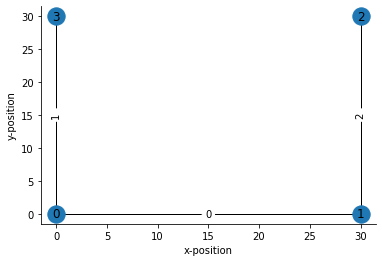

In [2]:
from track_linearization import make_track_graph, plot_track_graph
import matplotlib.pyplot as plt

node_positions = [(0, 0), # xy position of node 0
                  (30, 0), # xy position of node 1
                  (30, 30), # xy position of node 2
                  (0, 30), # xy position of node 3
                 ]

edges = [(0, 1), # connects node 0 and node 1
         (0, 3), # connects node 0 and node 3
         (1, 2), # connects node 1 and node 2
        ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

TypeError: plot_graph_as_1D() got an unexpected keyword argument 'linear_zero_node_id'

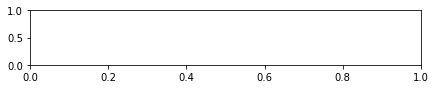

In [3]:
from track_linearization.utils import plot_graph_as_1D

linear_zero_node_id = 3
edge_order = [1, 0, 2]
edge_spacing = 0

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(track_graph,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 linear_zero_node_id=linear_zero_node_id,
                 ax=ax)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

x = np.linspace(0, 30)

position = np.concatenate(
    (
        np.stack((np.zeros_like(x), x[::-1]), axis=1),
        np.stack((x, np.zeros_like(x)), axis=1),
        np.stack((np.ones_like(x) * 30, x), axis=1)
    )
)
position += multivariate_normal(mean=0, cov=.5).rvs(position.shape)

plt.scatter(position[:50, 0], position[:50, 1], s=10, zorder=11)
plt.scatter(position[50:100, 0], position[50:100, 1], s=10, zorder=11)
plt.scatter(position[100:, 0], position[100:, 1], s=10, zorder=11)

In [ ]:
from track_linearization import get_linearized_position

position_df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    linear_zero_node_id=linear_zero_node_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(60, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(90, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 60, 90])
ax.set_ylim([0, 90])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

## Alternate Scheme

In [ ]:
from track_linearization.core import classify_track_segments

route_euclidean_distance_scaling=1.0
sensor_std_dev=5.0
diagonal_bias=0.0

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias)

In [ ]:
from track_linearization.core import get_track_segments_from_graph, project_points_to_segment

def _calulcate_linear_position2(track_graph, position, track_segment_id,
                                edge_order, edge_spacing):
    is_nan = np.isnan(track_segment_id)
    track_segment_id[is_nan] = 0  # need to check
    track_segment_id = track_segment_id.astype(int)

    track_segments = get_track_segments_from_graph(track_graph)
    projected_track_positions = project_points_to_segment(
        track_segments, position)
    n_time = projected_track_positions.shape[0]
    projected_track_positions = projected_track_positions[(
        np.arange(n_time), track_segment_id)]

    n_edges = len(edge_order)
    if isinstance(edge_spacing, int) | isinstance(edge_spacing, float):
        edge_spacing = [edge_spacing, ] * (n_edges - 1)

    counter = 0.0
    start_node_linear_position = []

    for ind, edge in enumerate(edge_order):
        start_node_linear_position.append(counter)

        try:
            counter += track_graph.edges[edge]["distance"] + edge_spacing[ind]
        except IndexError:
            pass

    start_node_linear_position = np.asarray(start_node_linear_position)
    
    track_segment_id_to_start_node_linear_position = {
        track_graph.edges[e]["edge_id"]: snlp
        for e, snlp in zip(edge_order, start_node_linear_position)}
    
    start_node_linear_position = np.asarray([
        track_segment_id_to_start_node_linear_position[edge_id]
        for edge_id in track_segment_id
    ])

    track_segment_id_to_edge = {track_graph.edges[e]["edge_id"]: e for e in edge_order}
    start_node_id = np.asarray([track_segment_id_to_edge[edge_id][0]
                                for edge_id in track_segment_id])
    start_node_2D_position = np.asarray(
        [track_graph.nodes[node]["pos"] for node in start_node_id])
    

    linear_position = start_node_linear_position + (
        np.linalg.norm(start_node_2D_position -
                       projected_track_positions, axis=1))
    linear_position[is_nan] = np.nan

    return (linear_position,
            projected_track_positions[:, 0],
            projected_track_positions[:, 1])

In [ ]:
edge_order = [(3, 0),
              (0, 1),
              (1, 2)]

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(60, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(90, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 60, 90])
ax.set_ylim([0, 90])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(60, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(90, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 60, 90])
ax.set_ylim([0, 90])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

In [ ]:
from track_linearization.utils import plot_graph_as_1D

linear_zero_node_id = 3
edge_order = [1, 0, 2]
edge_spacing = 10

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(track_graph,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 linear_zero_node_id=linear_zero_node_id,
                 ax=ax)
position_df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    linear_zero_node_id=linear_zero_node_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")


edge_order = [(3, 0),
              (0, 1),
              (1, 2)]

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

In [ ]:
from track_linearization.utils import plot_graph_as_1D

linear_zero_node_id = 2
edge_order = [2, 0, 1]
edge_spacing = 10

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(track_graph,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 linear_zero_node_id=linear_zero_node_id,
                 ax=ax)
position_df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    linear_zero_node_id=linear_zero_node_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")


edge_order = [(2, 1),
              (1, 0),
              (0, 3),]

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias)

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
from track_linearization.utils import plot_graph_as_1D

linear_zero_node_id = 2
edge_order = [2, 0, 1]
edge_spacing = 10

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(track_graph,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 linear_zero_node_id=linear_zero_node_id,
                 ax=ax)
position_df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    linear_zero_node_id=linear_zero_node_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")


edge_order = [(1, 0),
              (2, 1),
              (0, 3),]

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias)

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
from track_linearization.utils import plot_graph_as_1D

linear_zero_node_id = 2
edge_order = [2, 0, 1]
edge_spacing = 10

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(track_graph,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 linear_zero_node_id=linear_zero_node_id,
                 ax=ax)
position_df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    linear_zero_node_id=linear_zero_node_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], position_df.linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], position_df.linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], position_df.linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, position_df.linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")


edge_order = [(1, 0),
              (1, 2),
              (0, 3),]

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias)

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(position_df.index[:50], linear_position[:50], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[50:100], linear_position[50:100], s=10, zorder=2, clip_on=False)
ax.scatter(position_df.index[100:], linear_position[100:], s=10, zorder=2, clip_on=False)
ax.plot(position_df.index, linear_position, color="lightgrey", zorder=1, clip_on=False)
ax.axhline(30, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(40, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(70, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(80, color="black", zorder=0, linestyle="--", clip_on=False)
ax.axhline(110, color="black", zorder=0, linestyle="--", clip_on=False)
ax.set_yticks([0, 30, 40, 70, 80, 110])
ax.set_ylim([0, 110])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0, position_df.shape[0]))
ax.set_ylabel("Position")
ax.set_xlabel("Time")

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
def plot_graph_as_1D2(track_graph, edge_order=None, edge_spacing=0,
                      ax=None, axis="x", other_axis_start=0.0,
                      draw_edge_labels=False, node_size=300, node_color="#1f77b4"):
    
    if ax is None:
        ax = plt.gca()
    # If no edge_order is given, then arange edges in the order passed to
    # construct the track graph
    if edge_order is None:
        edge_order = np.asarray(track_graph.edges)
        
    n_edges = len(edge_order)
    if isinstance(edge_spacing, int) | isinstance(edge_spacing, float):
        edge_spacing = [edge_spacing, ] * (n_edges - 1)
        
    
    if axis == "x":
        start_node_linear_position = 0.0

        for ind, edge in enumerate(edge_order):
            end_node_linear_position = start_node_linear_position + track_graph.edges[edge]["distance"]
            ax.scatter(start_node_linear_position, other_axis_start,
                       zorder=8, s=node_size, clip_on=False, color=node_color)
            ax.scatter(end_node_linear_position, other_axis_start,
                        zorder=8, s=node_size, clip_on=False, color=node_color)
            ax.plot((start_node_linear_position, end_node_linear_position), (other_axis_start, other_axis_start), color="black")

            if draw_edge_labels:
                edge_midpoint = start_node_linear_position + (end_node_linear_position - start_node_linear_position) / 2
                ax.scatter(edge_midpoint, other_axis_start, color="white",
                    zorder=9, s=node_size, clip_on=False)
                ax.text(edge_midpoint, other_axis_start, track_graph.edges[edge]["edge_id"],
                         ha="center", va="center", zorder=10)

            ax.text(start_node_linear_position, other_axis_start, edge[0], ha="center", va="center", zorder=10)
            ax.text(end_node_linear_position, other_axis_start, edge[1], ha="center", va="center", zorder=10)

            try:
                start_node_linear_position += track_graph.edges[edge]["distance"] + edge_spacing[ind]
            except IndexError:
                pass

        ax.set_xlim((other_axis_start, end_node_linear_position))
        ax.set_xlabel("Linear Position [cm]")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_yticks([])
    elif axis == "y":
        start_node_linear_position = 0.0

        for ind, edge in enumerate(edge_order):
            end_node_linear_position = start_node_linear_position + track_graph.edges[edge]["distance"]
            ax.scatter(other_axis_start, start_node_linear_position,
                       zorder=8, s=node_size, clip_on=False, color=node_color)
            ax.scatter(other_axis_start, end_node_linear_position, 
                        zorder=8, s=node_size, clip_on=False, color=node_color)
            ax.plot((other_axis_start, other_axis_start), (start_node_linear_position, end_node_linear_position), color="black")
            
            if draw_edge_labels:
                edge_midpoint = start_node_linear_position + (end_node_linear_position - start_node_linear_position) / 2
                ax.scatter(other_axis_start, edge_midpoint, color="white",
                           zorder=9, s=node_size, clip_on=False)
                ax.text(other_axis_start, edge_midpoint, track_graph.edges[edge]["edge_id"],
                         ha="center", va="center", zorder=10)

            ax.text(other_axis_start, start_node_linear_position, edge[0], ha="center", va="center", zorder=10)
            ax.text(other_axis_start, end_node_linear_position, edge[1], ha="center", va="center", zorder=10)

            try:
                start_node_linear_position += track_graph.edges[edge]["distance"] + edge_spacing[ind]
            except IndexError:
                pass
        ax.set_ylabel("Linear Position [cm]")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 1))
plot_graph_as_1D2(track_graph, edge_order=edge_order, edge_spacing=10,
                  ax=ax)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Circle

In [ ]:
angle = np.linspace(-np.pi, np.pi, num=12, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots(figsize=(7, 6))
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
center_well_id = 11
edge_order = np.arange(len(track_graph.nodes))
edge_spacing = 0

fig, ax = plt.subplots(figsize=(20, 1))
plot_graph_as_1D(track_graph, edge_order, edge_spacing,
                 center_well_id, ax=ax)

In [ ]:
position_angles = np.linspace(-np.pi, np.pi, num=1000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)
position += multivariate_normal(mean=0, cov=.5).rvs(position.shape)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(position[:, 0], position[:, 1], alpha=0.5, s=10, zorder=11, color="orange")

In [ ]:
edge_order = np.stack((np.arange(len(track_graph.nodes)),
                       np.roll(np.arange(len(track_graph.nodes)), -1)), axis=1)

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev,
    diagonal_bias=diagonal_bias)

linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 1))
plot_graph_as_1D2(track_graph, edge_order=edge_order, edge_spacing=edge_spacing,
                  ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(np.arange(linear_position.size), linear_position, s=10)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(np.arange(linear_position.size), linear_position, s=10)
plot_graph_as_1D2(track_graph, edge_order=edge_order, edge_spacing=edge_spacing,
                  ax=ax, axis="y", other_axis_start=1001)
ax.set_ylim((linear_position.min(), linear_position.max()))
ax.set_xlim((0, linear_position.size))

In [ ]:
import pandas as pd

nodes_df = (pd.DataFrame.from_dict(dict(track_graph1.nodes(data=True)), orient="index")
            .assign(x_pos=lambda df: np.asarray(list(df.pos))[:, 0])
            .assign(y_pos=lambda df: np.asarray(list(df.pos))[:, 1])
            .drop(columns="pos")
           )
node_linear_position, _, _ = _calulcate_linear_position2(track_graph, nodes_df.loc[:, ["x_pos", "y_pos"]].values, nodes_df.edge_id,
                                                    edge_order, edge_spacing)
nodes_df["linear_position"] = node_linear_position
nodes_df = nodes_df.rename_axis(index="node_id")
edge_avg_linear_position = nodes_df.groupby("edge_id").linear_position.mean().rename("edge_avg_linear_position")

nodes_df = (pd.merge(nodes_df.reset_index(), edge_avg_linear_position, on="edge_id")
            .sort_values(by=['linear_position', 'edge_avg_linear_position'], axis='rows')
            .set_index("node_id")
            .drop(columns="edge_avg_linear_position")
           )
nodes_df

In [ ]:
original_nodes_df = nodes_df.loc[list(track_graph.nodes)]
original_nodes_df

In [ ]:
place_bin_edges_nodes_df = (nodes_df
                            .loc[~nodes_df.index.isin(list(track_graph.nodes)) & nodes_df.is_bin_edge]
                            )
place_bin_edges_nodes_df

In [ ]:
place_bin_centers_nodes_df = (nodes_df.loc[~nodes_df.is_bin_edge])

place_bin_centers_nodes_df

In [ ]:
plt.figure(figsize=(10, 10))
plot_track_graph(track_graph)
plt.scatter(place_bin_edges_nodes_df.x_pos, place_bin_edges_nodes_df.y_pos, color="black", zorder=10)
plt.scatter(place_bin_centers_nodes_df.x_pos, place_bin_centers_nodes_df.y_pos, color="orange", zorder=10)

In [ ]:
plt.figure(figsize=(20, 1))
plt.scatter(place_bin_edges_nodes_df.linear_position, np.zeros_like(place_bin_edges_nodes_df.linear_position), color="black")
plt.scatter(place_bin_centers_nodes_df.linear_position, np.zeros_like(place_bin_centers_nodes_df.linear_position), color="orange")

In [ ]:
place_bin_centers_nodes_df.linear_position.values

In [ ]:
def get_track_grid(
        track_graph, center_well_id, edge_order, edge_spacing, place_bin_size):
    track_graph_with_bin_centers_edges = make_track_graph_with_bin_centers_edges(track_graph, place_bin_size)
    nodes_df = extract_bin_info_from_track_graph(track_graph, track_graph_with_bin_centers_edges, edge_order, edge_spacing)

    original_nodes_df = nodes_df.loc[list(track_graph.nodes)].reset_index()
    place_bin_edges_nodes_df = nodes_df.loc[~nodes_df.index.isin(list(track_graph.nodes)) & nodes_df.is_bin_edge].reset_index()
    place_bin_centers_nodes_df = nodes_df.loc[~nodes_df.is_bin_edge].reset_index()

    place_bin_edges = place_bin_edges_nodes_df.drop_duplicates("linear_position").linear_position
    place_bin_centers = get_centers(place_bin_edges)

    # Compute distance between nodes
    distance_between_nodes = dict(
        nx.all_pairs_dijkstra_path_length(track_graph_with_bin_centers_edges, weight="distance"))

    change_edge_ind = np.nonzero(np.diff(place_bin_edges_nodes_df.drop_duplicates("linear_position").edge_id))[0]
    
    # Figure out which points are on the track and not just gaps
    if isinstance(edge_spacing, int) | isinstance(edge_spacing, float):
        n_edges = len(edge_order)
        edge_spacing = [edge_spacing, ] * (n_edges - 1)

    is_track_interior = np.ones_like(place_bin_centers, dtype=np.bool)
    not_track = change_edge_ind[np.array(edge_spacing) > 0]
    is_track_interior[not_track] = False
    
    # Add information about bin centers not on track
    place_bin_centers_nodes_df = (
        pd.concat((place_bin_centers_nodes_df,
               pd.DataFrame({"linear_position": place_bin_centers[~is_track_interior],
                             "node_id": -1,
                             "edge_id": -1,
                             "is_bin_edge": False,
                            })))
     .sort_values(by=['linear_position'], axis='rows')).reset_index(drop=True)
    
    # Other needed information
    edges = [place_bin_edges]
    centers_shape = (place_bin_centers.size,)
    
    return (
        place_bin_centers[:, np.newaxis],
        place_bin_edges[:, np.newaxis],
        is_track_interior,
        distance_between_nodes,
        centers_shape,
        edges,
        track_graph_with_bin_centers_edges,
        original_nodes_df,
        place_bin_edges_nodes_df,
        place_bin_centers_nodes_df,
        nodes_df.reset_index(),
    )


angle = np.linspace(-np.pi, np.pi, num=12, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)
edge_order = np.stack((np.arange(len(track_graph.nodes)),
                       np.roll(np.arange(len(track_graph.nodes)), -1)), axis=1)
edge_spacing = 0
place_bin_size = 5

(
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    centers_shape,
    edges,
    track_graph_with_bin_centers_edges,
    original_nodes_df,
    place_bin_edges_nodes_df,
    place_bin_centers_nodes_df,
    nodes_df,
 ) = get_track_grid(
    track_graph, center_well_id, edge_order,
    edge_spacing, place_bin_size)

In [ ]:
class Decoder:
    def __init__(self, nodes_df, track_graph_with_bin_centers_edges):
        self._nodes_df = nodes_df
        self.track_graph_ = track_graph_with_bin_centers_edges
        
decoder = Decoder(nodes_df, track_graph_with_bin_centers_edges)

In [ ]:
import copy

import dask.bag as db
import networkx as nx
import numpy as np



def _distance_to_bin_centers(left_node, right_node, distance_left_node,
                             distance_right_node, time_ind, copy_graph,
                             place_bin_center_node_ids):
    node_name = f"actual_position_{time_ind}"
    copy_graph.add_node(node_name)
    copy_graph.add_edge(
        left_node, node_name, distance=distance_left_node)
    copy_graph.add_edge(
        node_name, right_node, distance=distance_right_node)
    distance_to_bin_centers = [
        nx.shortest_path_length(
            copy_graph, source=bin_center, target=node_name,
            weight="distance")
        for bin_center in place_bin_center_node_ids]
    copy_graph.remove_node(node_name)

    return distance_to_bin_centers


def _find_adjacent_nodes(nodes_df, linear_position):
    # Find the index of the nodes to insert between
    right_bin_ind = np.searchsorted(
        nodes_df.linear_position.values, linear_position, side="right")
    left_bin_ind = right_bin_ind - 1
    
    # Fix indices that are exactly the maximum bin edge
    n_bins = nodes_df.linear_position.shape[0]
    right_bin_ind[right_bin_ind >= n_bins] -= 1 

    # Fix indices that fall into invalid track positions
    # Note: Need to test on different binnings
    # Another solution is to find the edge this falls on directly.
    not_same_edge = (nodes_df.edge_id.values[left_bin_ind] !=
                     nodes_df.edge_id.values[right_bin_ind])
    right_bin_ind[not_same_edge] = right_bin_ind[not_same_edge] - 1
    left_bin_ind[not_same_edge] = left_bin_ind[not_same_edge] - 1

    # Get adjacent node names and distance
    left_node = nodes_df.reset_index().node_id.values[left_bin_ind]
    right_node = nodes_df.reset_index().node_id.values[right_bin_ind]

    distance_left_node = np.abs(
        nodes_df.loc[left_node].linear_position.values - linear_position)
    distance_right_node = np.abs(
        nodes_df.loc[right_node].linear_position.values - linear_position)

    return left_node, right_node, distance_left_node, distance_right_node


def get_distance_to_bin_centers(linear_position, decoder, npartitions=100):
    copy_graph = copy.deepcopy(decoder.track_graph_)
    linear_position = linear_position.squeeze()
    nodes_df = decoder._nodes_df.set_index("node_id")
    place_bin_center_node_ids = (
        nodes_df
        .loc[~nodes_df.is_bin_edge]
        .reset_index()
        .node_id
        .values)
    (left_node, right_node, distance_left_node,
     distance_right_node) = _find_adjacent_nodes(nodes_df, linear_position)

    left_node = db.from_sequence(
        left_node, npartitions=npartitions)
    right_node = db.from_sequence(
        right_node, npartitions=npartitions)
    distance_left_node = db.from_sequence(
        distance_left_node, npartitions=npartitions)
    distance_right_node = db.from_sequence(
        distance_right_node, npartitions=npartitions)
    time_ind = db.from_sequence(
        range(linear_position.shape[0]), npartitions=npartitions)

    return np.asarray(left_node.map(
        _distance_to_bin_centers, right_node, distance_left_node,
        distance_right_node, time_ind, copy_graph,
        place_bin_center_node_ids).compute())


def gaussian_kernel(distance, bandwidth):
    return (np.exp(-0.5 * (distance / bandwidth)**2) /
            (bandwidth * np.sqrt(2.0 * np.pi))) / bandwidth


In [ ]:
distance_to_bin_centers = get_distance_to_bin_centers(linear_position, decoder, npartitions=100)

In [ ]:
ind = 0
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 1
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 100
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 200
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 300
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 500
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 700
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
plt.plot(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers, 10).mean(axis=0))
plt.hist(linear_position, bins=place_bin_edges.squeeze(), density=True, zorder=-1)
plt.ylim((0, 0.01))

In [ ]:
edge_spacing = 10
place_bin_size = 5
linear_position, _, _ = _calulcate_linear_position2(track_graph, position, track_segment_id,
                             edge_order, edge_spacing)

(
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    centers_shape,
    edges,
    track_graph_with_bin_centers_edges,
    original_nodes_df,
    place_bin_edges_nodes_df,
    place_bin_centers_nodes_df,
    nodes_df,
 ) = get_track_grid(
    track_graph, center_well_id, edge_order,
    edge_spacing, place_bin_size)

decoder = Decoder(nodes_df, track_graph_with_bin_centers_edges)
distance_to_bin_centers = get_distance_to_bin_centers(linear_position, decoder, npartitions=100)

ind = 700
plt.scatter(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 0
plt.scatter(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
ind = 500
plt.scatter(place_bin_centers[is_track_interior], gaussian_kernel(distance_to_bin_centers[ind], 10))
plt.axvline(linear_position[ind], color="black")

In [ ]:
plt.scatter(place_bin_centers[is_track_interior],
            gaussian_kernel(distance_to_bin_centers, 10).mean(axis=0), zorder=100, color="orange")
plt.hist(linear_position, bins=place_bin_edges.squeeze(), density=True, zorder=-1)
plt.ylim((0, 0.01))

In [ ]:
gaussian_dbc = gaussian_kernel(distance_to_bin_centers, 10)

In [ ]:
gaussian_dbc.shape

In [ ]:
blah = get_distance_to_bin_centers(linear_position, decoder, npartitions=100)


In [ ]:
blah.compute()

In [ ]:
track_graph